In [ ]:
!pip install psycopg2-binary sqlalchemy missingno fuzzywuzzy python-levenshtein kaggle

import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from google.colab import files
import zipfile
import glob
import os
from scipy import stats

print("Please upload your kaggle.json file:")
uploaded = files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("Kaggle API token configured successfully.")

db_config = {
    'user': 'cinema_admin',
    'password': '<DB_PASSWORD>',
    'host': '<DB_HOST>',
    'port': '5432',
    'dbname': 'cinema_db'
}

connection_str = f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['dbname']}"
engine = create_engine(connection_str)

print("Connecting to SQL Database to retrieve active Movie IDs...")
try:
    with engine.connect() as connection:
        query = text("SELECT DISTINCT movie_id FROM app_sales")
        result = connection.execute(query)
        valid_movie_ids = [row[0] for row in result]
    print(f"Retrieved {len(valid_movie_ids)} unique movie IDs from the Sales System.")
except Exception as e:
    print(f"Error connecting to database: {e}")
    valid_movie_ids = []

dataset_slug = "asaniczka/tmdb-movies-dataset-2023-930k-movies"
!kaggle datasets download -d {dataset_slug}

zip_name = dataset_slug.split('/')[-1] + ".zip"
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall("tmdb_data")

csv_files = glob.glob("tmdb_data/*.csv")
csv_path = csv_files[0]
df_raw = pd.read_csv(csv_path, low_memory=False)

df_movies = df_raw[df_raw['id'].isin(valid_movie_ids)].copy()
print(f"Filtered DataFrame shape: {df_movies.shape}")

print("\n--- INFO ---")
df_movies.info()

print("\n--- MISSING VALUES ---")
print(df_movies.isnull().sum())

msno.matrix(df_movies, color=(0.2, 0.4, 0.6))
plt.title("Matrix of Missing Values", fontsize=20)
plt.show()

print("\n--- DUPLICATES ---")
doublons = df_movies.duplicated(subset=['id'])
print(f"Number of duplicate IDs: {doublons.sum()}")
if doublons.sum() > 0:
    df_movies = df_movies.drop_duplicates(subset=['id'])
    print("Duplicates removed.")

print("\n--- OUTLIER DETECTION (Budget) ---")
df_movies['budget'] = pd.to_numeric(df_movies['budget'], errors='coerce').fillna(0)

Q1 = df_movies['budget'].quantile(0.25)
Q3 = df_movies['budget'].quantile(0.75)
IQR = Q3 - Q1
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")

valeurs_aberrantes = df_movies[(df_movies['budget'] < (Q1 - 1.5 * IQR)) | (df_movies['budget'] > (Q3 + 1.5 * IQR))]
print(f"Number of outlier rows detected in Budget: {len(valeurs_aberrantes)}")

median_budget = df_movies[df_movies['budget'] > 0]['budget'].median()
df_movies['budget'] = df_movies['budget'].replace(0, median_budget)
print(f"Replaced 0 values in budget with median: {median_budget}")

print("\n--- DATA IMPUTATION ---")

df_movies['homepage'] = df_movies['homepage'].fillna("N/A")
print("Imputed 'homepage' with 'N/A'")

df_movies['tagline'] = df_movies['tagline'].fillna("No Tagline Available")
print("Imputed 'tagline' with 'No Tagline Available'")

df_movies['keywords'] = df_movies['keywords'].fillna("")
print("Imputed 'keywords' with empty string")

print("\n--- FINAL VERIFICATION ---")
print(df_movies[['id', 'title', 'budget', 'homepage', 'tagline']].head())
print(df_movies.isnull().sum())

output_filename = "filtered_tmdb_movies_sample.csv"
df_movies.to_csv(output_filename, index=False)
print(f"\nSaved cleaned data to {output_filename}")
files.download(output_filename)

In [ ]:
import requests
import pandas as pd
import numpy as np
from google.colab import files

# ==========================================
# 1. Configuration
# ==========================================
cities = {
    "Tunis":  {"lat": 36.8065, "lon": 10.1815},
    "Sousse": {"lat": 35.8256, "lon": 10.6084},
    "Sfax":   {"lat": 34.7406, "lon": 10.7603}
}

# Matching the logic of the sales generation
START_DATE = "2023-12-20"
END_DATE = "2025-12-20"

# ==========================================
# 2. Helper Functions (Business Logic)
# ==========================================

def get_weather_state(code):
    """
    Maps WMO Weather Codes to General States.
    """
    if code in [0, 1]:
        return "Clear"
    elif code in [2, 3]:
        return "Cloudy"
    elif code in [45, 48]:
        return "Foggy"
    elif code in [51, 53, 55, 61, 63, 65, 80, 81, 82]:
        return "Rainy"
    elif code in [71, 73, 75, 77, 85, 86]:
        return "Snow/Hail"
    elif code in [95, 96, 99]:
        return "Stormy"
    else:
        return "Unknown"

def get_temp_category(temp):
    """
    Categorizes temperature based on Tunisian averages.
    """
    if temp < 13:
        return "Cold"       # Good for cinema (Indoor activity)
    elif 13 <= temp < 25:
        return "Mild"       # Outdoor competition
    elif 25 <= temp < 32:
        return "Warm"       # Neutral
    else:
        return "Hot"        # Good for cinema (AC seeking)

# ==========================================
# 3. Data Fetching Loop
# ==========================================
all_data = []

print(f"📡 Connecting to Open-Meteo API...")
print(f"📅 Fetching data from {START_DATE} to {END_DATE}...\n")

for city_name, coords in cities.items():
    print(f"   Processing {city_name}...")

    # Open-Meteo Archive API
    url = "https://archive-api.open-meteo.com/v1/archive"

    # Updated parameters to include precipitation and daylight
    params = {
        "latitude": coords["lat"],
        "longitude": coords["lon"],
        "start_date": START_DATE,
        "end_date": END_DATE,
        "daily": [
            "weather_code",
            "temperature_2m_max",
            "precipitation_sum",    # Total rain in mm
            "daylight_duration"     # Seconds of daylight
        ],
        "timezone": "auto"
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status() # Check for HTTP errors

        data = response.json()
        daily = data['daily']

        # Create DataFrame
        df_city = pd.DataFrame({
            'date': daily['time'],
            'max_temp': daily['temperature_2m_max'],
            'wmo_code': daily['weather_code'],
            'precipitation_mm': daily['precipitation_sum'],
            'daylight_seconds': daily['daylight_duration']
        })

        df_city['city'] = city_name

        # --- Transformations ---

        # 1. Map Weather State (Text)
        df_city['weather_state'] = df_city['wmo_code'].apply(get_weather_state)

        # 2. Map Temp Category (Text)
        df_city['temp_category'] = df_city['max_temp'].apply(get_temp_category)

        # 3. Convert Daylight to Hours (More readable)
        df_city['daylight_hours'] = (df_city['daylight_seconds'] / 3600).round(2)

        # Append to list
        all_data.append(df_city)

    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching {city_name}: {e}")

# ==========================================
# 4. Final Aggregation & Save
# ==========================================
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)

    # Select and reorder columns for the Data Warehouse
    output_columns = [
        'city',
        'date',
        'weather_state',
        'temp_category',
        'max_temp',           # Kept as specific measure
        'precipitation_mm',   # New useful metric
        'daylight_hours'      # New useful metric
    ]

    output_df = final_df[output_columns]

    print("\n✅ Data Fetching Complete!")
    print(f"   Total Records: {len(output_df)}")
    print("\nSample Data:")
    print(output_df.head(5))

    # Save to CSV
    filename = "tunisia_historical_weather.csv"
    output_df.to_csv(filename, index=False)
    print(f"\n💾 Saved to '{filename}'")

    # Download
    files.download(filename)
else:
    print("No data fetched. Please check API connection.")

In [ ]:
!pip install pygrametl

In [ ]:
import pandas as pd
import psycopg2
import pygrametl
from psycopg2.extras import execute_values
from pygrametl.tables import CachedDimension, FactTable
from pygrametl.datasources import SQLSource
from datetime import datetime, timedelta
import sys

# ==========================================
# 1. CONFIGURATION & CONNECTION
# ==========================================
db_config = {
    'user': 'cinema_admin',
    'password': '<DB_PASSWORD>',
    'host': '<DB_HOST>',
    'port': '5432',
    'dbname': 'cinema_db'
}

try:
    connection = psycopg2.connect(**db_config)
    # Pandas requires a SQLAlchemy engine or a raw connection. We use raw here.
    connection_wrapper = pygrametl.ConnectionWrapper(connection)
    connection_wrapper.setasdefault()
    print("✅ Connected to the Data Warehouse (PostgreSQL).")
except Exception as e:
    print(f"❌ Connection Failed: {e}")
    sys.exit(1)

# ==========================================
# 2. TRANSFORMATION LOGIC
# ==========================================
def get_age_group(age):
    if not age: return 'Unknown'
    if age < 18: return 'Teen'
    elif age < 30: return 'Young Adult'
    elif age < 60: return 'Adult'
    else: return 'Senior'

def get_runtime_category(runtime):
    if not runtime or runtime == 0: return 'Unknown'
    if runtime < 90: return 'Short'
    elif runtime <= 150: return 'Medium'
    else: return 'Long'

def get_date_key(date_obj):
    if isinstance(date_obj, str):
        date_obj = datetime.strptime(date_obj, "%Y-%m-%d")
    return int(date_obj.strftime('%Y%m%d'))

# ==========================================
# 3. DEFINE TARGET TABLES
# ==========================================
# Dimensions
dim_date = CachedDimension(
    name='dw.Dim_Date',
    key='date_key',
    attributes=['full_date', 'day_name', 'day_of_week', 'is_weekend', 'month_name', 'quarter', 'year']
)

dim_movie = CachedDimension(
    name='dw.Dim_Movie',
    key='movie_key',
    attributes=['movie_source_id', 'title', 'primary_genre', 'runtime', 'runtime_category', 'vote_average', 'budget', 'release_year'],
    lookupatts=['movie_source_id']
)

dim_theater = CachedDimension(
    name='dw.Dim_Theater',
    key='theater_key',
    attributes=['theater_source_id', 'theater_name', 'city', 'capacity_factor'],
    lookupatts=['theater_source_id']
)

dim_customer = CachedDimension(
    name='dw.Dim_Customer',
    key='customer_key',
    attributes=['customer_source_id', 'gender', 'age', 'age_group', 'city'],
    lookupatts=['customer_source_id']
)

dim_weather = CachedDimension(
    name='dw.Dim_Weather',
    key='weather_key',
    attributes=['city', 'date_ref', 'weather_state', 'temp_category', 'min_temp', 'max_temp', 'precipitation_mm', 'daylight_hours'],
    lookupatts=['city', 'date_ref']
)

# ==========================================
# 4. ETL PROCESS EXECUTION
# ==========================================
print("\n🚀 Starting ETL Pipeline (PANDAS VECTORIZED)...")

# --- 4.1 Load Dim_Date ---
print("   -> Loading Dim_Date...")
start_date = datetime(2023, 12, 1)
end_date = datetime(2026, 1, 1)
current_day = start_date
while current_day <= end_date:
    d_key = get_date_key(current_day)
    day_num = current_day.weekday()
    is_wknd = True if day_num >= 5 else False
    dim_date.insert({
        'date_key': d_key,
        'full_date': current_day.date(),
        'day_name': current_day.strftime('%A'),
        'day_of_week': day_num + 1,
        'is_weekend': is_wknd,
        'month_name': current_day.strftime('%B'),
        'quarter': (current_day.month - 1) // 3 + 1,
        'year': current_day.year
    })
    current_day += timedelta(days=1)

# --- 4.2 Load Dim_Movie ---
print("   -> Loading Dim_Movie...")
df_movies = pd.read_csv('filtered_tmdb_movies_sample.csv')
for _, row in df_movies.iterrows():
    genres = str(row['genres']).split(',')
    p_genre = genres[0].strip() if len(genres) > 0 else 'Unknown'
    dim_movie.insert({
        'movie_source_id': row['id'],
        'title': row['title'],
        'primary_genre': p_genre,
        'runtime': row['runtime'],
        'runtime_category': get_runtime_category(row['runtime']),
        'vote_average': row['vote_average'],
        'budget': row['budget'],
        'release_year': pd.to_datetime(row['release_date']).year
    })

# --- 4.3 Load Dim_Weather ---
print("   -> Loading Dim_Weather...")
df_weather = pd.read_csv('tunisia_historical_weather.csv')
for _, row in df_weather.iterrows():
    dim_weather.insert({
        'city': row['city'],
        'date_ref': datetime.strptime(row['date'], "%Y-%m-%d").date(),
        'weather_state': row['weather_state'],
        'temp_category': row['temp_category'],
        'min_temp': 0,
        'max_temp': row['max_temp'],
        'precipitation_mm': row['precipitation_mm'],
        'daylight_hours': row['daylight_hours']
    })

# --- 4.4 Load Dim_Theater ---
print("   -> Loading Dim_Theater...")
source_theaters = SQLSource(connection=connection, query="SELECT * FROM app_theaters")
for row in source_theaters:
    dim_theater.insert({
        'theater_source_id': row['theater_id'],
        'theater_name': row['name'],
        'city': row['city'],
        'capacity_factor': float(row['capacity_factor'])
    })

# --- 4.5 Load Dim_Customer (BULK) ---
print("   -> Loading Dim_Customer (BULK)...")
# Note: Using pandas read_sql is much faster than SQLSource loop
df_raw_cust = pd.read_sql("SELECT * FROM app_customers", connection)
if not df_raw_cust.empty:
    df_raw_cust['age_group'] = df_raw_cust['age'].apply(get_age_group)

    # Prepare data for bulk insert
    # Order must match columns in DB: customer_source_id, gender, age, age_group, city
    cust_tuples = list(df_raw_cust[['customer_id', 'gender', 'age', 'age_group', 'city']].itertuples(index=False, name=None))

    print(f"      Inserting {len(cust_tuples)} customers...")
    insert_query = "INSERT INTO dw.Dim_Customer (customer_source_id, gender, age, age_group, city) VALUES %s"
    with connection.cursor() as cursor:
        execute_values(cursor, insert_query, cust_tuples)
    connection.commit()

# --- 4.6 Load Fact_Ticket_Sales (PANDAS MERGE OPTIMIZATION) ---
print("   -> Loading Fact_Ticket_Sales (VECTORIZED MERGE)...")

# 1. Fetch Sales (Transactional Data) - 1 Network Request
print("      Fetching Sales Data...")
df_sales = pd.read_sql("SELECT * FROM app_sales", connection)

# 2. Fetch Keys from Dimensions (Lookups) - 4 Network Requests
print("      Fetching Dimension Keys...")
df_dim_movie = pd.read_sql("SELECT movie_key, movie_source_id FROM dw.Dim_Movie", connection)
df_dim_theater = pd.read_sql("SELECT theater_key, theater_source_id FROM dw.Dim_Theater", connection)
df_dim_cust = pd.read_sql("SELECT customer_key, customer_source_id FROM dw.Dim_Customer", connection)
df_dim_weather = pd.read_sql("SELECT weather_key, city, date_ref FROM dw.Dim_Weather", connection)

# 3. Perform Merges (Lookups in Memory - Instant)
print("      Merging Dataframes...")

# Join Movie
df_fact = df_sales.merge(df_dim_movie, left_on='movie_id', right_on='movie_source_id', how='left')

# Join Theater
df_fact = df_fact.merge(df_dim_theater, left_on='theater_id', right_on='theater_source_id', how='left')

# Join Customer
df_fact = df_fact.merge(df_dim_cust, left_on='customer_id', right_on='customer_source_id', how='left')

# Join Weather (Composite Key: City + Date)
# Ensure dates are compatible types (usually objects/dates from pandas read_sql are compatible)
df_fact = df_fact.merge(df_dim_weather, left_on=['city', 'date_key'], right_on=['city', 'date_ref'], how='left')

# 4. Transform Date Key to Integer (YYYYMMDD)
df_fact['date_key_int'] = pd.to_datetime(df_fact['date_key']).dt.strftime('%Y%m%d').astype(int)

# 5. Prepare Final Tuple List for Bulk Insert
print("      Preparing Bulk Insert...")
# Select only necessary columns in correct order for Insert
final_df = df_fact[[
    'transaction_id',
    'date_key_int',
    'theater_key',
    'movie_key',
    'customer_key',
    'weather_key',
    'ticket_price',
    'quantity',
    'total_amount'
]]

# Drop rows where keys might be missing (data integrity)
final_df = final_df.dropna()

data_to_insert = list(final_df.itertuples(index=False, name=None))

if data_to_insert:
    print(f"      Sending {len(data_to_insert)} sales transactions to DB...")
    insert_fact_query = """
        INSERT INTO dw.Fact_Ticket_Sales
        (transaction_id, date_key, theater_key, movie_key, customer_key, weather_key, ticket_price, quantity, total_amount)
        VALUES %s
    """
    with connection.cursor() as cursor:
        execute_values(cursor, insert_fact_query, data_to_insert)
    connection.commit()

# ==========================================
# 5. FINALIZATION
# ==========================================
connection.close()
print(f"\n✅ ETL Complete! All data loaded successfully.")

In [ ]:
# Re-open connection just for verification
try:
    conn = psycopg2.connect(**db_config)
    cursor = conn.cursor()

    print("--- DATA WAREHOUSE HEALTH CHECK ---\n")

    # 1. Check Row Counts
    tables = ['dw.Dim_Movie', 'dw.Dim_Theater', 'dw.Dim_Customer', 'dw.Dim_Weather', 'dw.Fact_Ticket_Sales']
    for t in tables:
        cursor.execute(f"SELECT COUNT(*) FROM {t}")
        count = cursor.fetchone()[0]
        print(f"✅ {t}: {count} rows")

    print("\n--- DATA INTEGRITY CHECK (Sample Join) ---")
    # 2. Check if we can actually join facts to dimensions (e.g., Revenue by City)
    query = """
    SELECT
        t.city,
        COUNT(f.sales_key) as total_tickets,
        SUM(f.total_amount) as total_revenue
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Theater t ON f.theater_key = t.theater_key
    GROUP BY t.city
    ORDER BY total_revenue DESC;
    """

    cursor.execute(query)
    results = cursor.fetchall()

    print(f"{'City':<15} | {'Tickets':<10} | {'Revenue (TND)':<15}")
    print("-" * 45)
    for row in results:
        print(f"{row[0]:<15} | {row[1]:<10} | {row[2]:<15,.2f}")

    conn.close()

except Exception as e:
    print(e)

--- DATA WAREHOUSE HEALTH CHECK ---

✅ dw.Dim_Movie: 200 rows
✅ dw.Dim_Theater: 3 rows
✅ dw.Dim_Customer: 48031 rows
✅ dw.Dim_Weather: 2196 rows
✅ dw.Fact_Ticket_Sales: 241418 rows

--- DATA INTEGRITY CHECK (Sample Join) ---
City            | Tickets    | Revenue (TND)  
---------------------------------------------
Tunis           | 117062     | 1,806,740.00   
Sousse          | 75629      | 940,448.00     
Sfax            | 48727      | 508,424.00     


✅ Connected to Data Warehouse for Analysis.


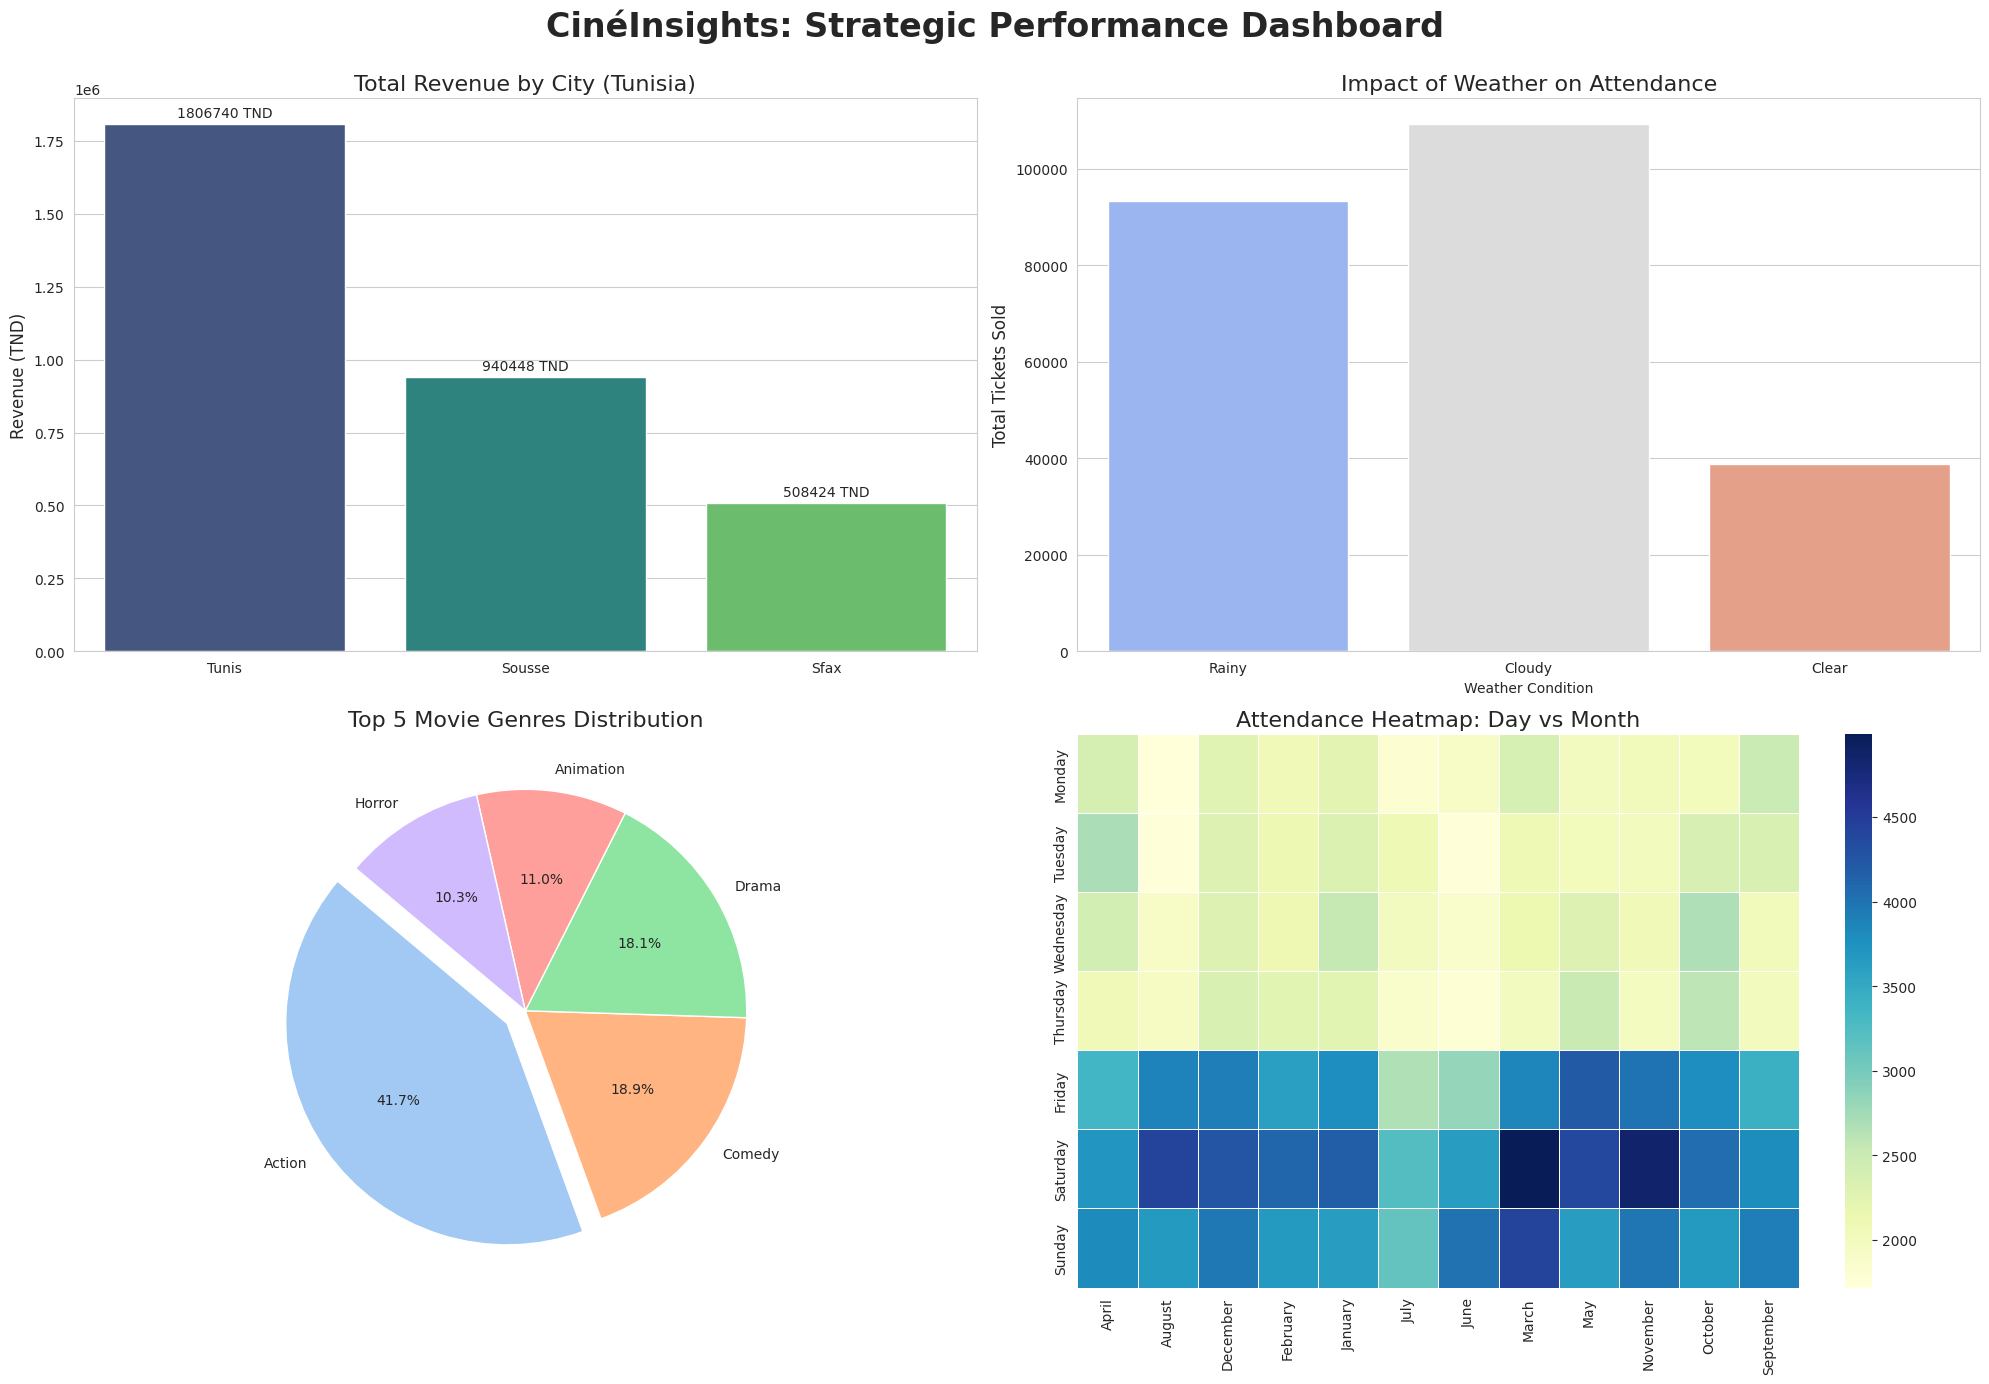

In [ ]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATABASE CONNECTION
# ==========================================
db_config = {
    'user': 'cinema_admin',
    'password': '<DB_PASSWORD>',
    'host': '<DB_HOST>',
    'port': '5432',
    'dbname': 'cinema_db'
}

try:
    conn = psycopg2.connect(**db_config)
    print("✅ Connected to Data Warehouse for Analysis.")
except Exception as e:
    print(f"❌ Connection Failed: {e}")

# ==========================================
# 2. DATA RETRIEVAL (SQL QUERIES)
# ==========================================

# KPI 1: Revenue by City (Bar Chart)
# Validates the "Weighted Cities" logic (Tunis > Sousse > Sfax)
query_revenue_city = """
    SELECT
        dt.city,
        SUM(f.total_amount) as total_revenue
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Theater dt ON f.theater_key = dt.theater_key
    GROUP BY dt.city
    ORDER BY total_revenue DESC;
"""

# KPI 2: Sales Volume by Weather Condition (Box/Bar Plot)
# Validates the "Rainy = Cinema" logic
query_weather_sales = """
    SELECT
        dw.weather_state,
        AVG(f.total_amount) as avg_daily_revenue,
        COUNT(DISTINCT f.transaction_id) as total_tickets
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Weather dw ON f.weather_key = dw.weather_key
    WHERE dw.weather_state IN ('Clear', 'Cloudy', 'Rainy', 'Stormy')
    GROUP BY dw.weather_state
    ORDER BY avg_daily_revenue DESC;
"""

# KPI 3: Top 5 Genres (Pie Chart)
# Validates customer preference
query_genres = """
    SELECT
        dm.primary_genre,
        COUNT(*) as tickets_sold
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Movie dm ON f.movie_key = dm.movie_key
    WHERE dm.primary_genre != 'Unknown'
    GROUP BY dm.primary_genre
    ORDER BY tickets_sold DESC
    LIMIT 5;
"""

# KPI 4: Attendance Heatmap (Day of Week vs Month)
# Validates the "Weighted Days" logic (Fri/Sat/Sun)
query_heatmap = """
    SELECT
        dd.day_name,
        dd.month_name,
        COUNT(*) as ticket_volume
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Date dd ON f.date_key = dd.date_key
    GROUP BY dd.day_name, dd.month_name, dd.day_of_week, dd.quarter
    ORDER BY dd.day_of_week;
"""

# Load into Pandas
df_city = pd.read_sql(query_revenue_city, conn)
df_weather = pd.read_sql(query_weather_sales, conn)
df_genre = pd.read_sql(query_genres, conn)
df_heatmap = pd.read_sql(query_heatmap, conn)

conn.close()

# ==========================================
# 3. DASHBOARD GENERATION
# ==========================================

# Set global style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))
plt.suptitle('CinéInsights: Strategic Performance Dashboard', fontsize=24, weight='bold', y=0.95)

# --- CHART 1: Total Revenue by City ---
plt.subplot(2, 2, 1)
ax1 = sns.barplot(x='city', y='total_revenue', data=df_city, palette='viridis')
plt.title('Total Revenue by City (Tunisia)', fontsize=16)
plt.ylabel('Revenue (TND)', fontsize=12)
plt.xlabel('')
# Add labels on bars
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.0f TND', padding=3)

# --- CHART 2: Average Ticket Volume by Weather ---
plt.subplot(2, 2, 2)
# Normalize for better visualization if difference is huge, or just plot raw
sns.barplot(x='weather_state', y='total_tickets', data=df_weather, palette='coolwarm')
plt.title('Impact of Weather on Attendance', fontsize=16)
plt.ylabel('Total Tickets Sold', fontsize=12)
plt.xlabel('Weather Condition')

# --- CHART 3: Top Genres Market Share ---
plt.subplot(2, 2, 3)
plt.pie(df_genre['tickets_sold'], labels=df_genre['primary_genre'], autopct='%1.1f%%',
        startangle=140, colors=sns.color_palette('pastel'), explode=(0.1, 0, 0, 0, 0))
plt.title('Top 5 Movie Genres Distribution', fontsize=16)

# --- CHART 4: Attendance Heatmap ---
plt.subplot(2, 2, 4)
# Pivot the data for heatmap format
heatmap_data = df_heatmap.pivot(index='day_name', columns='month_name', values='ticket_volume')
# Reorder days
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(days_order)
# Reorder months (simple list for 2024/2025 mix)
months_order = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data[heatmap_data.columns.intersection(months_order)]

sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, linewidths=.5)
plt.title('Attendance Heatmap: Day vs Month', fontsize=16)
plt.ylabel('')
plt.xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

✅ Connected to Data Warehouse for Advanced Analysis.


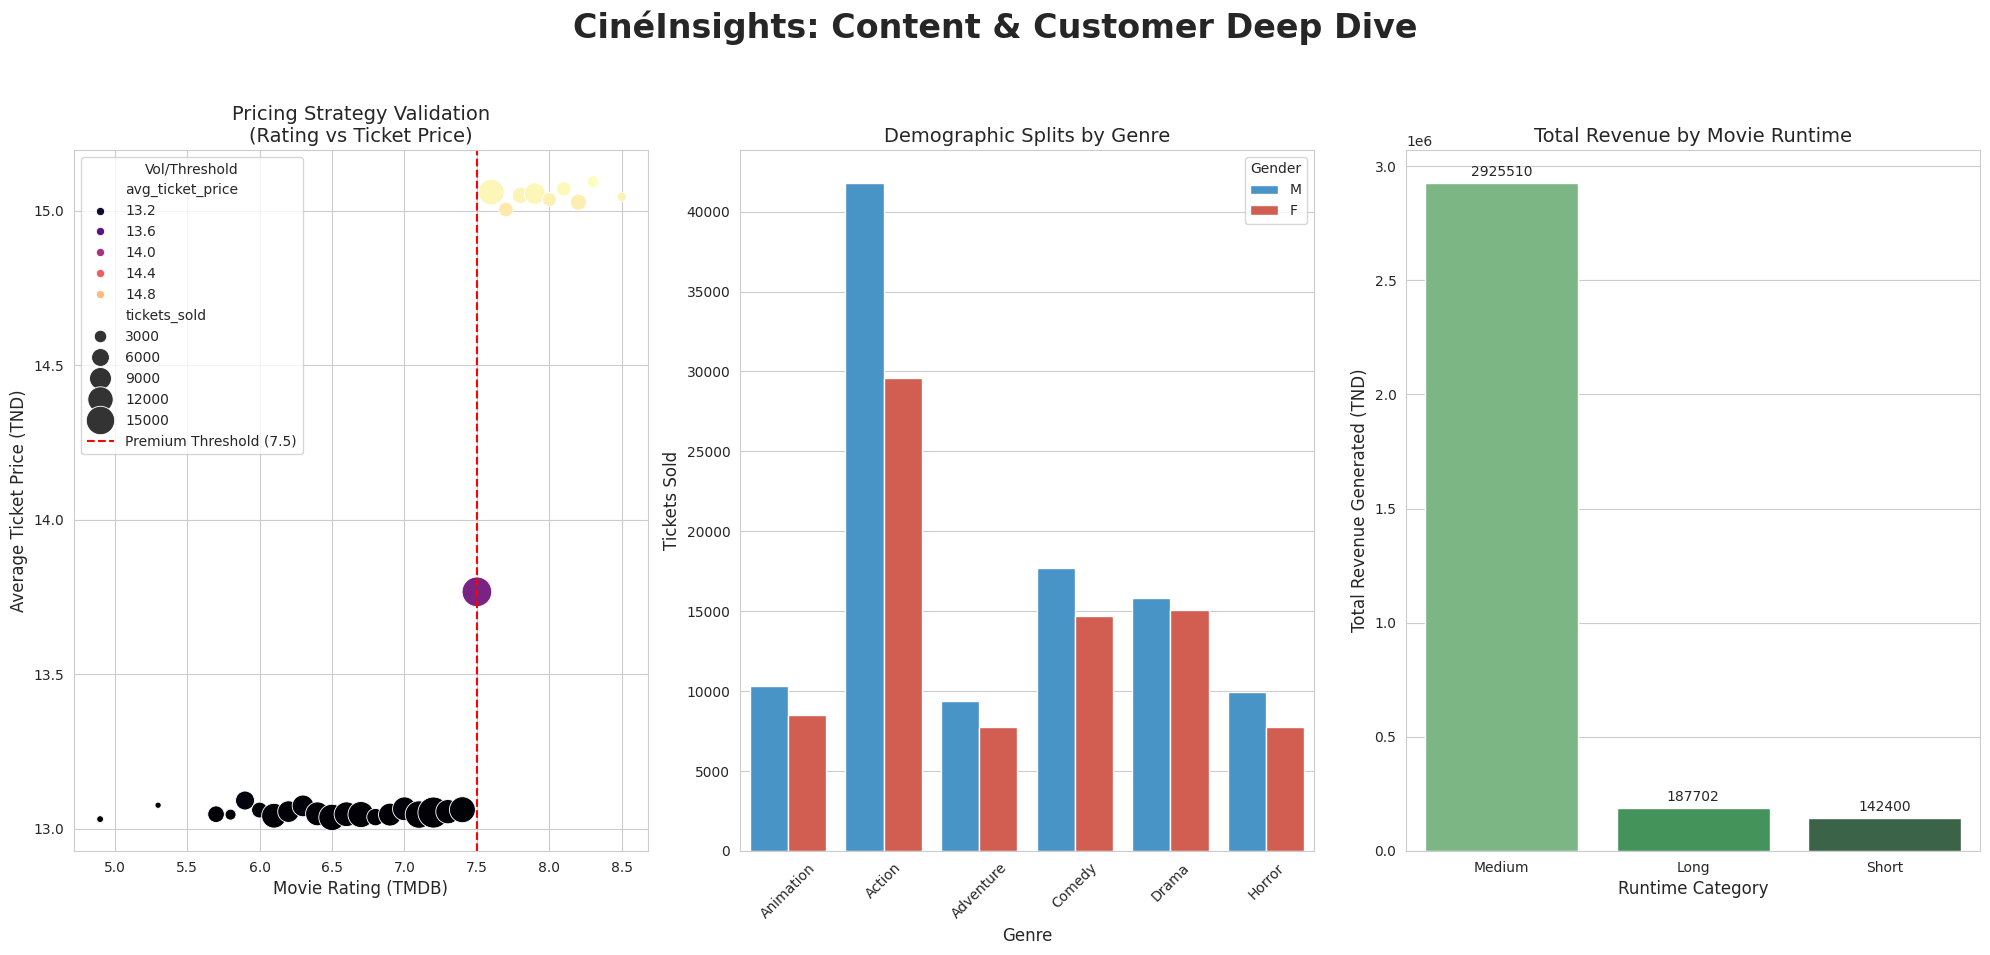

In [ ]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# ==========================================
# 1. DATABASE CONNECTION
# ==========================================
db_config = {
    'user': 'cinema_admin',
    'password': '<DB_PASSWORD>',
    'host': '<DB_HOST>',
    'port': '5432',
    'dbname': 'cinema_db'
}

try:
    conn = psycopg2.connect(**db_config)
    print("✅ Connected to Data Warehouse for Advanced Analysis.")
except Exception as e:
    print(f"❌ Connection Failed: {e}")

# ==========================================
# 2. ADVANCED DATA RETRIEVAL
# ==========================================

# Analysis 5: Price Logic Validation (Rating vs. Ticket Price)
# Did the system correctly charge more for movies with Vote > 7.5?
query_price_logic = """
    SELECT
        ROUND(dm.vote_average, 1) as rating,
        AVG(f.ticket_price) as avg_ticket_price,
        COUNT(*) as tickets_sold
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Movie dm ON f.movie_key = dm.movie_key
    WHERE dm.vote_average > 0
    GROUP BY ROUND(dm.vote_average, 1)
    ORDER BY rating;
"""

# Analysis 6: Gender vs. Genre Correlation
# Do demographics match the genre assumptions (e.g., Action -> Male)?
query_gender_genre = """
    SELECT
        dm.primary_genre,
        dc.gender,
        COUNT(*) as ticket_volume
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Movie dm ON f.movie_key = dm.movie_key
    JOIN dw.Dim_Customer dc ON f.customer_key = dc.customer_key
    WHERE dm.primary_genre IN (
        SELECT primary_genre FROM dw.Dim_Movie
        GROUP BY primary_genre ORDER BY COUNT(*) DESC LIMIT 6
    )
    GROUP BY dm.primary_genre, dc.gender;
"""

# Analysis 7: Runtime Performance
# Do "Long" movies earn less due to fewer screening slots (the simulation penalty)?
query_runtime = """
    SELECT
        dm.runtime_category,
        AVG(f.total_amount) as avg_revenue_per_sale,
        SUM(f.total_amount) as total_revenue
    FROM dw.Fact_Ticket_Sales f
    JOIN dw.Dim_Movie dm ON f.movie_key = dm.movie_key
    WHERE dm.runtime_category != 'Unknown'
    GROUP BY dm.runtime_category
    ORDER BY total_revenue DESC;
"""

# Load Dataframes
df_price = pd.read_sql(query_price_logic, conn)
df_gender = pd.read_sql(query_gender_genre, conn)
df_runtime = pd.read_sql(query_runtime, conn)

conn.close()

# ==========================================
# 3. DASHBOARD PAGE 2: CONTENT & CUSTOMER INSIGHTS
# ==========================================

sns.set_style("whitegrid")
plt.figure(figsize=(20, 10)) # Wider layout
plt.suptitle('CinéInsights: Content & Customer Deep Dive', fontsize=24, weight='bold', y=0.98)

# --- CHART 5: Price Logic (Rating vs Price) ---
plt.subplot(1, 3, 1)
# Scatter plot with size representing volume
scatter = sns.scatterplot(
    data=df_price,
    x='rating',
    y='avg_ticket_price',
    size='tickets_sold',
    sizes=(20, 500),
    hue='avg_ticket_price',
    palette='magma'
)
# Add a vertical line at 7.5 (The logic threshold)
plt.axvline(x=7.5, color='red', linestyle='--', label='Premium Threshold (7.5)')
plt.title('Pricing Strategy Validation\n(Rating vs Ticket Price)', fontsize=14)
plt.xlabel('Movie Rating (TMDB)', fontsize=12)
plt.ylabel('Average Ticket Price (TND)', fontsize=12)
plt.legend(title='Vol/Threshold')

# --- CHART 6: Gender Demographics by Genre ---
plt.subplot(1, 3, 2)
# Grouped Bar Chart
sns.barplot(
    data=df_gender,
    x='primary_genre',
    y='ticket_volume',
    hue='gender',
    palette={'M': '#3498db', 'F': '#e74c3c'}
)
plt.title('Demographic Splits by Genre', fontsize=14)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Tickets Sold', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Gender')

# --- CHART 7: Runtime Efficiency ---
plt.subplot(1, 3, 3)
# Bar chart for Total Revenue
ax3 = sns.barplot(
    data=df_runtime,
    x='runtime_category',
    y='total_revenue',
    palette='Greens_d'
)
plt.title('Total Revenue by Movie Runtime', fontsize=14)
plt.xlabel('Runtime Category', fontsize=12)
plt.ylabel('Total Revenue Generated (TND)', fontsize=12)

# Annotate bars
for container in ax3.containers:
    ax3.bar_label(container, fmt='%.0f', padding=3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()